In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/modified.csv")
df.head(2)

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,...,is_month_end,discount_pct,net_price,competitor_gap,Units Sold_lag1,Units Sold_lag7,Units Sold_lag14,Units Sold_lag28,Units Sold_rmean7,Units Sold_rmean28
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,...,0,0.2,26.800,-2.890,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-02,S001,P0001,Groceries,West,116,81,104,92.94,27.95,...,0,0.1,25.155,-5.735,127.0,NaN,NaN,NaN,NaN,NaN


In [3]:
df = df.dropna(subset=["Units Sold_lag1", "Units Sold_rmean7", "Units Sold_rmean28"])
df = df.drop(columns=["Date"])

target = "Units Sold"
X = df.drop(columns = [target])
y = df[target]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71700 entries, 14 to 73099
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Store ID            71700 non-null  object 
 1   Product ID          71700 non-null  object 
 2   Category            71700 non-null  object 
 3   Region              71700 non-null  object 
 4   Inventory Level     71700 non-null  int64  
 5   Units Sold          71700 non-null  int64  
 6   Units Ordered       71700 non-null  int64  
 7   Demand Forecast     71700 non-null  float64
 8   Price               71700 non-null  float64
 9   Discount            71700 non-null  int64  
 10  Weather Condition   71700 non-null  object 
 11  Holiday/Promotion   71700 non-null  int64  
 12  Competitor Pricing  71700 non-null  float64
 13  Seasonality         71700 non-null  object 
 14  dow                 71700 non-null  int64  
 15  week                71700 non-null  int64  
 16  month   

In [10]:
categorical_cols = [
    "Store ID", "Product ID", "Category", "Region", "Weather Condition",
    "Seasonality", "Holiday/Promotion"
]
numeric_cols = [col for col in X.columns if col not in categorical_cols]

numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = 1)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 1)


model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

model.fit(X_train, y_train)

y_pred = model.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
print(f"Validation MSE: {mse:.2f}")

Validation MSE: 75.06


---
# ARIMA Approach

In [21]:
df = pd.read_csv("data/modified.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")
df.head(3)

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,...,is_month_end,discount_pct,net_price,competitor_gap,Units Sold_lag1,Units Sold_lag7,Units Sold_lag14,Units Sold_lag28,Units Sold_rmean7,Units Sold_rmean28
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,...,0,0.2,26.800,-2.890,NaN,NaN,NaN,NaN,NaN,NaN
46784,2022-01-01,S004,P0005,Groceries,North,397,200,172,196.57,81.72,...,0,0.0,81.720,-3.500,NaN,NaN,NaN,NaN,NaN,NaN
2193,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,...,0,0.1,29.448,-5.292,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# For now subset by individual product and store
subset = df[(df["Store ID"] == "S001") & (df["Product ID"] == "P0001")]

In [23]:
subset = subset.set_index("Date").asfreq("D")
subset["Units Sold"] = subset["Units Sold"].interpolate()

train_size = int(len(subset) * 0.8)
train, test = subset.iloc[:train_size], subset.iloc[train_size:]

# p,d,q 
model = ARIMA(train["Units Sold"], order = (2,1,2))
fitted = model.fit()

forecast = fitted.forecast(steps=len(test))
mse = mean_squared_error(test["Units Sold"], forecast)
print(f"ARIMA(2,1,2) MSE: {mse:.3f}")

ARIMA(2,1,2) MSE: 11928.250


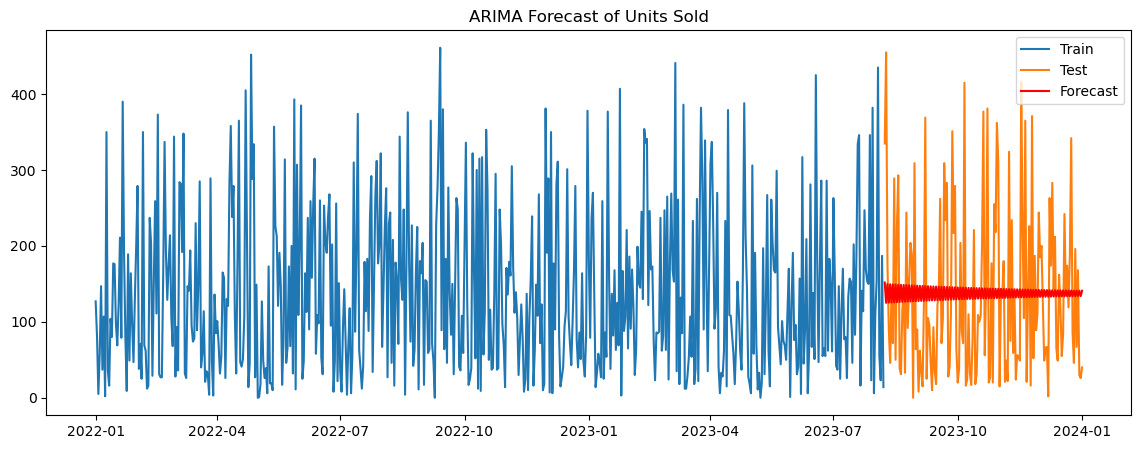

In [26]:
plt.figure(figsize = (14,5))
plt.plot(train.index, train["Units Sold"], label = "Train")
plt.plot(test.index, test["Units Sold"], label = "Test")
plt.plot(test.index, forecast, label="Forecast", color="red")
plt.legend()
plt.title("ARIMA Forecast of Units Sold")
plt.show()

In [25]:
11928.250 ** 0.5

109.21652805322096

In [ ]:
# TODO:
# - Implement Seasonality to ARIMA Model; 2,1,2 fails to pick up on patterns
# - Work on more robust non-time-series models, start with logreg, rf, 